In [11]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np

# Sensivity analysis when we change Latency

# Model Inputs
problem = {
    'num_vars': 5,
    'names': ['xLoad', 'zCapacity', 'zLatency', 'zAvailability', 'newLatency'],
    'bounds': [
                [100, 700], # load
                [0, 500], # capacity
                [10, 80], # latency
                [0, 1], # availability
                [10, 80] # new latency
               ]
}

# Suggesting N = 1000
param_values = saltelli.sample(problem, 10)

np.savetxt("..\out\sensitivity\param_values.txt", param_values, fmt='%1.4f')



Questions To Ask
- Do we want to have this model accept some combination of degradations at the same time or just one?
    > Limit it to just one degradation at a time
- Some scenarios have different architecture? Z has unlimited capacity in most scenarios.
    > I think we need 1 "model" per architecture. Also means, we may need to consider different input distributions per scenario, since they would each be a situation (i.e. we care about latency in this one, so our latency distribution is wider, etc)

In [20]:
# Outputs from Time Series
""" Some assistance from this article
https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
"""

def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

def time_series_crosscorr(d1, d2, window):
    """
    Returns crosscorr, delay
    """
    #rs = [crosscorr(d1, d2, lag) for lag in range(-window, 1)]
    rs = [crosscorr(d1, d2, lag) for lag in range(-window, 1)]

    # Early exit if no window
    if window == 0:
        #print(window, 0, rs)
        return rs[0], 0
    
    maxCrossCorr = np.amax(rs)
    maxCrossCorrIndex = np.argmax(rs)
    minCrossCorr = np.amin(rs)
    minCrossCorrIndex = np.argmin(rs)

    actualCrossCorr = 0
    actualCrossCorrIndex = 0

    if maxCrossCorr > -1 * minCrossCorr:
        actualCrossCorr = maxCrossCorr
        actualCrossCorrIndex = maxCrossCorrIndex
    else:
        actualCrossCorr = minCrossCorr
        actualCrossCorrIndex = minCrossCorrIndex

    offset = -window + actualCrossCorrIndex
    #print(window, actualCrossCorrIndex, rs)

    return actualCrossCorr, offset

In [63]:
import glob
import pandas as pd

def get_output(series):
    c_loadx_loady = crosscorr(series["loadFromX"], series["loadFromY"])
    c_loadx_laty = crosscorr(series["loadFromX"], series["meanLatencyFromY"])

    return [c_loadx_loady, c_loadx_laty]


time_series_path = "..\out\sensitivity\\results-1627078635970"
all_time_series_csv_files = glob.glob(time_series_path + "/*.csv")
time_series = [pd.read_csv(f) for f in all_time_series_csv_files]
outputs = [get_output(s) for s in time_series]

# transpose so we can just write each column as a file with normal array access
transposed = np.transpose(outputs)
single = transposed[1]
#print(outputs)
for index, o in enumerate(transposed):
    print("saving", o)
    np.savetxt(f"{time_series_path}\output_{index}_values.txt", o, fmt='%1.8f')

saving [nan nan nan  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. nan  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan  1.  1. nan  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. nan  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. nan  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. nan  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. nan  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
saving [            nan             nan             nan  1.53648522e-02
  4.90639676e-04  5.04209285e-03  4.83598191e-03  6.38128702e-03
  1.04724674e-03  1.07906032e-02 -3.93229350e-04 -3.81854652e-04
 -9.77084763e-03             nan -5.23713911e-03  2.34835787e-03
  1.27323099e-02  4.22905528e-03 -8.49915698e-03 -5.35701169e-03
  2.04240456e-03  1.88977248e-02 -1.39315221e-02 -1.21972597e-03
             nan             nan             nan             nan
             nan             nan           

Found Outputs: ['..\\out\\sensitivity\\results-1627078635970\\output_0_values.txt', '..\\out\\sensitivity\\results-1627078635970\\output_1_values.txt']


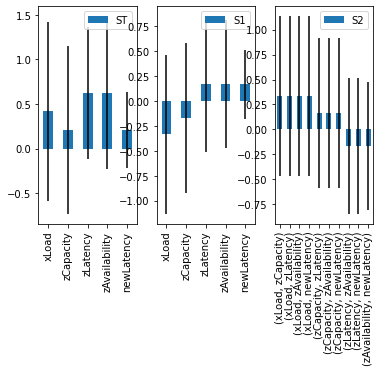

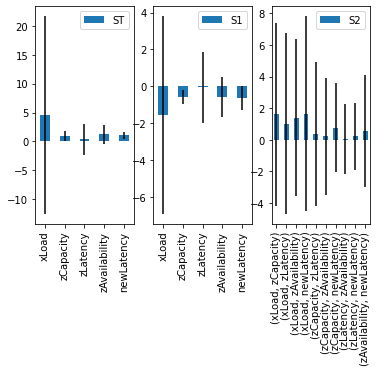

In [74]:
all_output_files = glob.glob(time_series_path + "/output_*_values.txt")
print("Found Outputs:", all_output_files)
outputs = [np.loadtxt(f, float) for f in all_output_files]
converted = [np.nan_to_num(o) for o in outputs]
analysis = [sobol.analyze(problem, o) for o in converted]
for a in analysis:
    a.plot()
#print(analysis)


#Y = np.loadtxt(time_series_path + "\output_values.txt", float)
#Y = np.nan_to_num(Y)
#Si = sobol.analyze(problem, Y)
#print(Si)
#print(Si['S1'])
#print(Si['ST'])
#Si.plot()